In [ ]:
import json
import re
import random
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import GPT2TokenizerFast

In [ ]:
# Project paths
# Unzip the Gutenburg Poetry Corpus to DATA_DIR before executing the code below
DATA_DIR = Path.home() / "./mockingbird/data"
NDJSON_PATH = DATA_DIR / "gutenberg-poetry-v001.ndjson"
FILTERED_PATH = DATA_DIR / "lyrical_poetry_subset.txt"
TOKENIZED_PATH = DATA_DIR / "tokenized_poetry_subset.json"


In [ ]:
with open(NDJSON_PATH, "r", encoding="utf-8") as f:
    for i, line in zip(range(5), f):
        print(line.strip())

{"s": "The Song of Hiawatha is based on the legends and stories of", "gid": "19"}
{"s": "many North American Indian tribes, but especially those of the", "gid": "19"}
{"s": "Ojibway Indians of northern Michigan, Wisconsin, and Minnesota.", "gid": "19"}
{"s": "They were collected by Henry Rowe Schoolcraft, the reknowned", "gid": "19"}
{"s": "Schoolcraft married Jane, O-bah-bahm-wawa-ge-zhe-go-qua (The", "gid": "19"}


In [ ]:
def is_lyrical(line):
    line = line.strip()
    if not line:
        return False
    words = line.split()
    if len(words) < 3 or len(words) > 10:
        return False
    if re.match(r"^(The|In|It|He|She|They|This|That|These|Those)\b", line):
        return False
    if not re.search(r"[aeiouy]", line[-3:].lower()):
        return False
    if re.search(r"^[A-Z\s0-9]+$", line):
        return False
    return True

In [ ]:
lyrical_lines = []
with open(NDJSON_PATH, "r", encoding="utf-8") as f:
    for i, line in enumerate(tqdm(f, desc="Filtering")):
        if i>200000:
            break
        obj = json.loads(line)
        s = obj["s"].strip()
        if is_lyrical(s):
            lyrical_lines.append(s)
print(f"Kept {len(lyrical_lines):,} lyrical lines")


Filtering: 200001it [00:00, 311361.90it/s]

Kept 121,749 lyrical lines


In [ ]:
with open(FILTERED_PATH, "w", encoding="utf-8") as f:
    f.write("\n".join(lyrical_lines))

In [ ]:
def clean_text(s):
    s = re.sub(r"\s+"," ",s)
    s = s.replace("“", '"').replace("”", '"').replace("’", "'")
    return s.strip()

cleaned_lines = [clean_text(l) for l in lyrical_lines]

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

encodings = tokenizer(cleaned_lines, truncation=True)
lengths = [len(e) for e in encodings["input_ids"]]

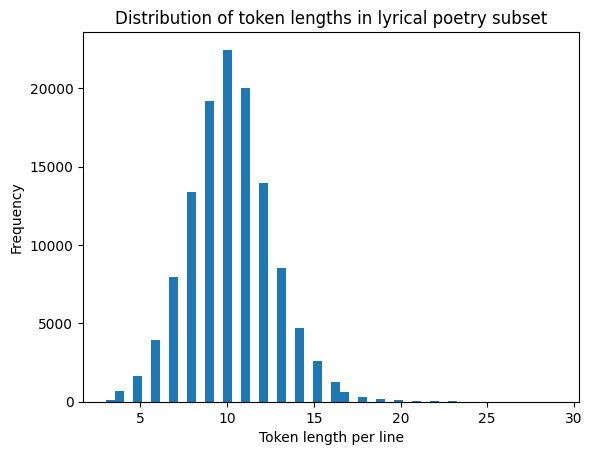

Average token length: 10.21


In [ ]:
plt.hist(lengths, bins=50)
plt.xlabel("Token length per line")
plt.ylabel("Frequency")
plt.title("Distribution of token lengths in lyrical poetry subset")
plt.show()

print(f"Average token length: {sum(lengths)/len(lengths):.2f}")

In [ ]:
import json

# Convert tokenizer output to plain Python lists
data_to_save = {
    "input_ids": [ids for ids in encodings["input_ids"]],
    "attention_mask": [mask for mask in encodings["attention_mask"]],
}

with open(TOKENIZED_PATH, "w", encoding="utf-8") as f:
    json.dump(data_to_save, f)

print(f"Saved tokenized dataset {TOKENIZED_PATH}")
print(f"Total samples: {len(data_to_save['input_ids']):,}")

In [ ]:
sample = random.choice(cleaned_lines)
print("Sample line:", sample)
print("Tokenized:", tokenizer.tokenize(sample))

Sample line: After the world that whilom tok
Tokenized: ['After', 'Ġthe', 'Ġworld', 'Ġthat', 'Ġwh', 'il', 'om', 'Ġto', 'k']
